In [3]:
from bs4 import BeautifulSoup
import re
import codecs

In [7]:
def parse_url(url, stop_words, min_len_word=1):
#   url?text#text -> url:
    temp = re.search(r'.+\?', url)
    if temp != None:
        url = temp.group(0)[:-1]
    temp = re.search(r'.+#', url)
    if temp != None:
        url = temp.group(0)[:-1]
    
#   site_name, full_domen, last_domen
    full_domen = re.search(r'\..+', url).group(0)[1:]
    if re.search(r'.+?/', full_domen) != None:
        full_domen = re.search(r'.+?/', full_domen).group(0)[:-1]    
    last_domen = full_domen.strip().split(sep='.')[-1]
    site_name = re.search(r'.+?\.', url).group(0)[:-1]
    
#   usefull_names = url.split() - domens - stop_words - set(word: len(word) < n)
    domens = full_domen.strip().split(sep='.')
    usefull_names = set(re.split('-|_|\.|/',url))
    usefull_names = usefull_names.difference(stop_words)
    usefull_names = usefull_names.difference(domens)
    usefull_names = [item for item in usefull_names if len(item) >= min_len_word]
    usefull_names = ' '.join(list(usefull_names))

        
    return full_domen, last_domen, site_name, usefull_names

In [8]:
path = 'content/'
stop_words = {''}
# stop_words = {'php', 'index', 'html', ''}
# stop_words = {'php', 'index', 'html', '', 'page', 'news', 'forum'}
# stop_words = {'php', 'index', 'html', '', 'page', 'news', 'forum', 'users', 'blog', 'topic', 'viewtopic', 'htm'}

In [9]:
output_txt = 'urls.txt'

open(output_txt, 'w')
with open(output_txt, 'a') as out_f:
    out_f.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format('doc_id', 'url', 'site_name', \
                                              'full_domen', 'last_domen', 'usefull_names'))
    for doc_id in range(1, 28027):
        with codecs.open(path + str(doc_id) + '.dat', 'r', 'utf-8') as in_f:
            url = in_f.readline().strip()
            full_domen, last_domen, site_name, usefull_names = parse_url(url, stop_words, min_len_word=3)
            out_f.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(doc_id, url, site_name, \
                                                      full_domen, last_domen, usefull_names))

In [10]:
output_txt = 'useful_names.txt'

open(output_txt, 'w')
with open(output_txt, 'a') as out_f:
    out_f.write('{}\t{}\n'.format('doc_id', 'useful_names'))
    for doc_id in range(1, 28027):
        with codecs.open(path + str(doc_id) + '.dat', 'r', 'utf-8') as in_f:
            url = in_f.readline().strip()
            full_domen, last_domen, site_name, usefull_names = parse_url(url, stop_words, min_len_word=3)
            out_f.write('{}\t{}\n'.format(doc_id, usefull_names))

In [11]:
# all_word_dict
output_txt = 'all_word_dict.txt'

open(output_txt, 'w')
with open(output_txt, 'a') as out_f:
    out_f.write('{}\t{}\n'.format('doc_id', 'useful_names'))
    for doc_id in range(1, 28027):
        with codecs.open(path + str(doc_id) + '.dat', 'r', 'utf-8') as in_f:
            url = in_f.readline().strip()
            _, _, _, usefull_names = parse_url(url, stop_words, min_len_word=0)
            usefull_names = usefull_names.strip().split()
            for i in usefull_names:
                out_f.write('{}\t{}\n'.format(doc_id, i))

In [17]:
import pandas as pd
import numpy as np

awd_df = pd.read_csv('all_word_dict.txt', sep='\t', encoding='utf-8', lineterminator='\n')


awd_df['total_counter'] = awd_df.groupby(by=['useful_names'])['useful_names'].transform(lambda s: len(s.values))

group_df = pd.read_csv('train_groups.csv', sep=',', encoding='utf-8', lineterminator='\n')
group_df = group_df[['doc_id', 'group_id']]
group_df.index = group_df.doc_id
group_df.drop('doc_id', inplace=True, axis=1)
group_df = group_df.sort_index()

awd_df = pd.merge(awd_df, group_df, on='doc_id', how='left')

group_df = pd.read_csv('test_groups.csv', sep=',', encoding='utf-8', lineterminator='\n')
group_df = group_df[['doc_id', 'group_id']]
group_df.index = group_df.doc_id
group_df.drop('doc_id', inplace=True, axis=1)
group_df = group_df.sort_index()

awd_df = pd.merge(awd_df, group_df, on='doc_id', how='left')
awd_df['group_id'] = awd_df.where(pd.notna(awd_df.group_id_x), awd_df.group_id_y, axis=0).group_id_x.astype(int)
awd_df.drop(['group_id_x','group_id_y'], inplace=True, axis=1)

awd_df['gr_counter'] = awd_df.groupby(by=['group_id', 'useful_names'])['useful_names'].transform('count')
awd_df['gr_docs'] = awd_df.groupby(by=['group_id'])['group_id'].transform('count')
awd_df['dc_counter'] = awd_df.groupby(by=['doc_id', 'useful_names'])['useful_names'].transform('count')
awd_df['dc_words'] = awd_df.groupby(by=['doc_id'])['doc_id'].transform('count')
awd_df['tfidf'] = (awd_df['dc_counter'] / awd_df['dc_words']) * np.log(awd_df['gr_docs'] / awd_df['gr_counter'])

awd_df.head()

,doc_id,useful_names,total_counter,group_id,gr_counter,gr_docs,dc_counter,dc_words,tfidf
0,1,5141,1,3,1,618,1,5,1.285298
1,1,zrenielib,15,3,1,618,1,5,1.285298
2,1,html,8126,3,41,618,1,5,0.542583
3,1,docs,199,3,2,618,1,5,1.146668
4,1,index,2034,3,14,618,1,5,0.757486


In [18]:
awd_df.tfidf.describe()

count    171082.000000
mean          0.889727
std           0.592696
min           0.079570
25%           0.505603
50%           0.732561
75%           1.077431
max           6.876265
Name: tfidf, dtype: float64

In [21]:
awd_df = awd_df[awd_df['gr_counter'] >= 2]
awd_df = awd_df[awd_df['tfidf'] >= 0.4]
awd_df = awd_df.sort_values(by=['doc_id'], ascending=True)
awd_df.head()

,doc_id,useful_names,total_counter,group_id,gr_counter,gr_docs,dc_counter,dc_words,tfidf
2,1,html,8126,3,41,618,1,5,0.542583
3,1,docs,199,3,2,618,1,5,1.146668
4,1,index,2034,3,14,618,1,5,0.757486
5,2,perevody,3,280,3,715,1,7,0.781953
6,2,perevesti,13,280,12,715,1,7,0.583911


In [23]:
temp_range = pd.DataFrame(np.arange(1, 28027), columns=['doc_id'])
temp = awd_df.groupby('doc_id')['useful_names'].apply(' '.join).reset_index()
temp = pd.merge(temp_range, temp, on='doc_id', how='left')
temp.fillna("").head()

,doc_id,useful_names
0,1,html docs index
1,2,perevody perevesti kak online
2,3,forum viewtopic php
3,4,v cat blogs
4,5,%D0%B1%D0%BE%D0%BB%D0%B5%D0%B7%D0%BD%D0%B8 jtb...


In [24]:
temp[['doc_id', 'useful_names']].to_csv("improved_useful_names.csv", index=False, sep='\t')

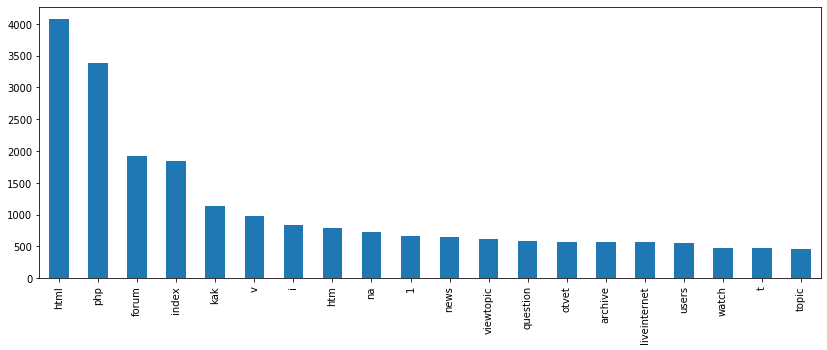

In [26]:
from matplotlib import pyplot as plt

fig = plt.figure(figsize= (14,5))
awd_df.useful_names.value_counts()[:20].plot.bar()

In [27]:
import pandas as pd

urls_df = pd.read_csv('urls.txt', sep='\t', encoding='utf-8', lineterminator='\n')
urls_df.index = urls_df.doc_id
urls_df.drop('doc_id', inplace=True, axis=1)
urls_df.head(10)

,url,site_name,full_domen,last_domen,usefull_names
doc_id,,,,,
1,zrenielib.ru/docs/index-5141.html,zrenielib,ru,ru,5141 zrenielib html docs index
2,kak-perevesti-online.ru/perevody-qiwi-wallet.html,kak-perevesti-online,ru,ru,perevody perevesti html kak wallet online qiwi
3,timecops.biz/forum/viewtopic.php?f=13&t=319,timecops,biz,biz,viewtopic timecops php forum
4,proffi95.ru/blogs/prepodavanie-v-nachalnyh-kla...,proffi95,ru,ru,prepodavanie cat 280 blogs nachalnyh proffi95 ...
5,xn----jtbaaldsgaoflxr4fyc.xn--p1ai/%D0%BD%D0%B...,xn----jtbaaldsgaoflxr4fyc,xn--p1ai,xn--p1ai,%D0%BA%D1%80%D0%BE%D0%B2%D0%B8 %D0%BD%D0%B0%D1...
6,rabotka.ru/resume,rabotka,ru,ru,resume rabotka
7,vladkakashi.beon.ru/raisin,vladkakashi,beon.ru,ru,vladkakashi raisin
8,doshkolnik.ru/zaniatia-s-detmi/7675-ladushki.html,doshkolnik,ru,ru,doshkolnik detmi html zaniatia 7675 ladushki
9,chastnosti.com/skolko-kalorij-v-dyne.html,chastnosti,com,com,chastnosti kalorij skolko html dyne


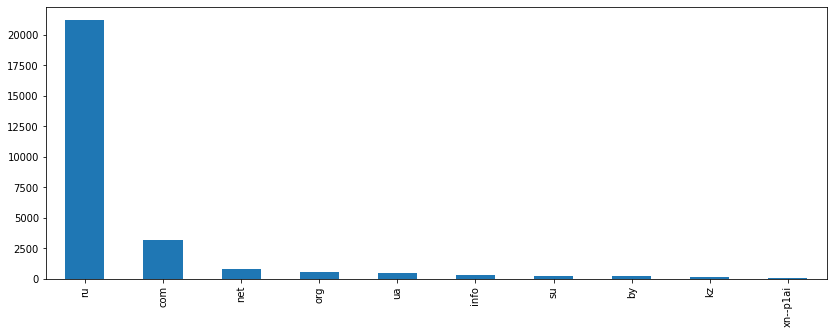

In [28]:
fig = plt.figure(figsize= (14,5))

urls_df.last_domen.value_counts()[:10].plot.bar()

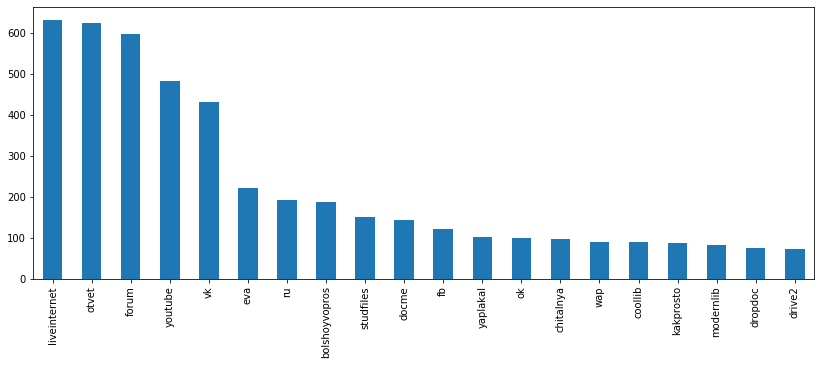

In [29]:
fig = plt.figure(figsize= (14,5))

urls_df.site_name.value_counts()[:20].plot.bar()

In [73]:
urls_df.last_domen.unique()

array(['ru', 'biz', 'xn--p1ai', 'com', 'me', 'by', 'az', 'net', 'sh',
       'club', 'bg', 'org', 'tv', 'info', 'eu', 'ua', 'ec', 'su', 'uz',
       'ws', 'co', 'kz', 'lv', 'br', 'mobi', 'cc', 'us', 'ml', 'tk', 'be',
       'in', 'fm', 'to', 'am', 'sd', 'ag', 'name', 'online', 'rs', 'pro',
       'guru', 'xyz', 'io', 'pl', 'bz', 'menu', 'gallery', 'nl', 'cz',
       'ng', 'ga', 'il', 'is', 'news', 'ar', 'hk', 'expert', 'today',
       'fi', 'jp', 'kg', 'space', 'so', 'pw', 'live', 'vn', 'wiki', 'ph',
       'es', 'it', 'md', 'travel', 'la', 'tools', 'ink', 'tj', 'bo',
       'studio', 'np', 'xn--p1acf', 'cab', 'ee', 'moe', 'de', 'tips',
       'win', 'top', 'cf', 'uk', 'ro', 'li', 'ir', 'click', 'life', 'gr',
       'ninja', 'gg', 'id', 'one', 'fr', 'center', 'st', 'christmas',
       'xxx', 'tech', 'at', 'cn'], dtype=object)